# Dynamic Social Network Analysis baised on GOT dataset

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')

## 1. Network Construction

In [2]:
# data file list
book_fnames = ['book1.csv', 'book2.csv', 'book3.csv', 'book4.csv', 'book5.csv']

# all books dataframe
all_books = pd.DataFrame()

# all books graphs
G_books = []

# read all books
for book_fname in book_fnames:
    book_path = 'raw/' + book_fname
    book = pd.read_csv(book_path)
    
    all_books = pd.concat([all_books, book], ignore_index=True)
    
    G_book = nx.Graph()
    for _, edge in book.iterrows():
        G_book.add_edge(edge['Source'], edge['Target'], weight=edge['weight'])
    G_books.append(G_book)

# save all books dataframe to csv
# all_books.to_csv("results/all_books.csv", index=False)

## 2. Character Importance Analysis

In [3]:
# Calculate the degree centrality of each node in each book and select the top 10 characters with the highest degree centrality
top_10_characters_per_book = []

for G_book in G_books:
    degree_centrality = nx.degree_centrality(G_book)
    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    top_10_characters = [character for character, centrality in sorted_degree_centrality[:10]]
    top_10_characters_per_book.append(top_10_characters)

# Count the number of times each character ranks in the top 10 across the five books
character_counts = {}
for top_10_characters in top_10_characters_per_book:
    for character in top_10_characters:
        if character in character_counts:
            character_counts[character] += 1
        else:
            character_counts[character] = 1

# Sort by the number of times ranked in the top 10
sorted_character_counts = sorted(character_counts.items(), key=lambda x: x[1], reverse=True)

# Print the results
print("Number of times characters ranked in the top 10 across the five books:")
for character, count in sorted_character_counts:
    print(f"{character}: {count} times")

Number of times characters ranked in the top 10 across the five books:
Tyrion-Lannister: 5 times
Cersei-Lannister: 5 times
Stannis-Baratheon: 4 times
Catelyn-Stark: 3 times
Jon-Snow: 3 times
Robb-Stark: 3 times
Sansa-Stark: 3 times
Joffrey-Baratheon: 3 times
Bran-Stark: 2 times
Arya-Stark: 2 times
Theon-Greyjoy: 2 times
Jaime-Lannister: 2 times
Eddard-Stark: 1 times
Robert-Baratheon: 1 times
Renly-Baratheon: 1 times
Brienne-of-Tarth: 1 times
Margaery-Tyrell: 1 times
Tommen-Baratheon: 1 times
Samwell-Tarly: 1 times
Petyr-Baelish: 1 times
Daenerys-Targaryen: 1 times
Barristan-Selmy: 1 times
Hizdahr-zo-Loraq: 1 times
Asha-Greyjoy: 1 times
Melisandre: 1 times


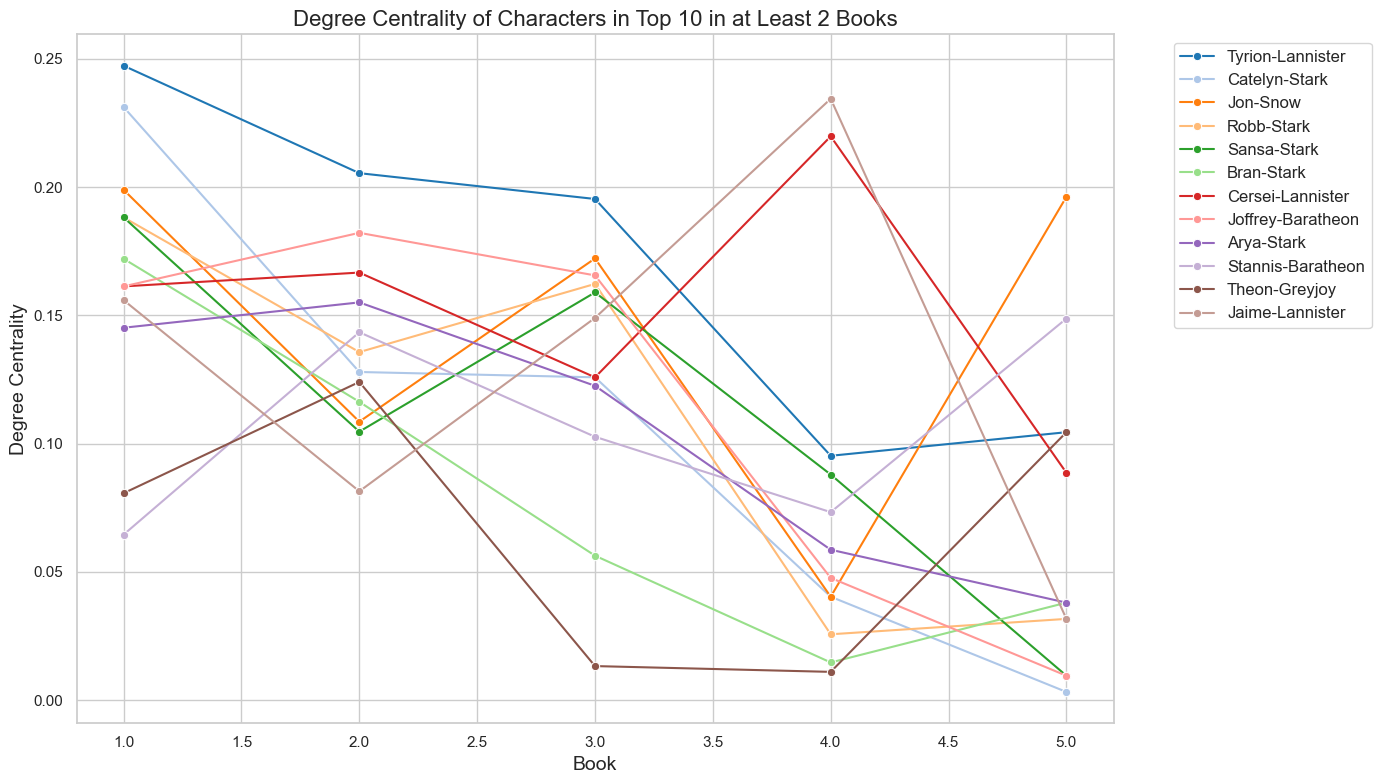

In [4]:
# Find characters that rank in the top 10 at least 2 times
characters_to_plot = [character for character, count in character_counts.items() if count >= 2]

# Prepare data
centrality_data = {character: [] for character in characters_to_plot}

for G_book in G_books:
    degree_centrality = nx.degree_centrality(G_book)
    for character in characters_to_plot:
        centrality_data[character].append(degree_centrality.get(character, 0))

# Convert to DataFrame for seaborn
centrality_df = pd.DataFrame(centrality_data)
centrality_df['Book'] = range(1, 6)
centrality_df = centrality_df.melt(id_vars='Book', var_name='Character', value_name='Degree Centrality')

# Plot with seaborn
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab20", len(characters_to_plot))

sns.lineplot(data=centrality_df, x='Book', y='Degree Centrality', hue='Character', marker='o', palette=palette)

plt.xlabel('Book', fontsize=14)
plt.ylabel('Degree Centrality', fontsize=14)
plt.title('Degree Centrality of Characters in Top 10 in at Least 2 Books', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save the plot
# plt.savefig('results/degree_centrality_plot.png')

plt.show()

## 3. Community Detection

In [5]:
# Perform community detection for the graph of each book
community_data = []

for book_id, G in enumerate(G_books):
    # Community detection
    partition = community_louvain.best_partition(G)
    
    # Save community information to the list
    for node, community in partition.items():
        community_data.append({'Book': book_id+1, 'Node': node, 'Community': community})

# Convert to DataFrame
community_df = pd.DataFrame(community_data)
    
# Save community results
# community_df.to_csv("results/community_results.csv", index=False)

Community detection results will be visualized in Gephi, named as 'bookn_network.png'

## 4. Community Dynamic Analysis

In [6]:
# Read community data
community_df = pd.read_csv("results/community_results.csv")

# Filter out communities with fewer than min_members
min_members = 5
community_df = community_df.groupby(['Book', 'Community']).filter(lambda x: len(x) >= min_members)

# Calculate the most important character's name and the number of members in each community
community_leaders = {}

for book_id in range(1, len(G_books)+1):
    # Get community data for the current book
    book_community_data = community_df[community_df['Book'] == book_id]
    
    # Get the graph for the current book
    G = G_books[book_id - 1]
    
    # Calculate the most important character's name and the number of members in each community
    for community in book_community_data['Community'].unique():
        # Get the nodes of the current community
        community_nodes = book_community_data[book_community_data['Community'] == community]['Node']
        
        # Calculate the degree centrality of each node
        centrality = nx.degree_centrality(G)
        
        # Find the node with the highest degree centrality
        leader = max(community_nodes, key=lambda node: centrality.get(node, 0))
        
        # Store the result
        community_leaders[(book_id, community)] = leader
        
# Display the results
for (book_id, community), leader in community_leaders.items():
    print(f"Book {book_id}, Community {community}: Leader = {leader}")


Book 1, Community 7: Leader = Tyrion-Lannister
Book 1, Community 1: Leader = Daenerys-Targaryen
Book 1, Community 2: Leader = Eddard-Stark
Book 1, Community 3: Leader = Jon-Snow
Book 1, Community 5: Leader = Sansa-Stark
Book 1, Community 6: Leader = Robb-Stark
Book 2, Community 1: Leader = Arya-Stark
Book 2, Community 0: Leader = Tyrion-Lannister
Book 2, Community 3: Leader = Jon-Snow
Book 2, Community 4: Leader = Theon-Greyjoy
Book 2, Community 5: Leader = Stannis-Baratheon
Book 2, Community 6: Leader = Daenerys-Targaryen
Book 3, Community 5: Leader = Tyrion-Lannister
Book 3, Community 8: Leader = Jaime-Lannister
Book 3, Community 3: Leader = Robb-Stark
Book 3, Community 4: Leader = Stannis-Baratheon
Book 3, Community 0: Leader = Robert-Baratheon
Book 3, Community 6: Leader = Jon-Snow
Book 3, Community 1: Leader = Arya-Stark
Book 3, Community 2: Leader = Bran-Stark
Book 4, Community 9: Leader = Jaime-Lannister
Book 4, Community 1: Leader = Cersei-Lannister
Book 4, Community 2: Leader 

In [7]:
# Create Source and Target columns to show the flow between communities
links_with_colors = []  # Initialize links_with_colors list
books = sorted(community_df["Book"].unique())

# Calculate community transfer rate and map colors
min_transfer_rate = 0.1  # Minimum transfer rate
max_transfer_rate = 1.0  # Maximum transfer rate

for i in range(len(books) - 1):
    # Data for the current and next time slices
    current = community_df[community_df["Book"] == books[i]]
    next_ = community_df[community_df["Book"] == books[i + 1]]

    # Merge data based on nodes
    merged = pd.merge(current, next_, on="Node", suffixes=("_current", "_next"))

    # Calculate community flow
    flows = merged.groupby(["Community_current", "Community_next"]).size().reset_index(name="count")

    # Construct link data
    for _, row in flows.iterrows():
        community_current = row["Community_current"]
        total_transfers = flows[flows["Community_current"] == community_current]["count"].sum()
        transfer_rate = row["count"] / total_transfers  # Calculate transfer rate

        # Adjust transparency range
        normalized_transfer = (transfer_rate - min_transfer_rate) / (max_transfer_rate - min_transfer_rate)
        normalized_transfer = max(0.15, min(normalized_transfer, 1))  # Set lower limit to 0.3

        # Map transfer rate to transparency (RGBA)
        base_color = (120, 149, 193)   # Base blue color
        rgba_color = f"rgba({base_color[0]}, {base_color[1]}, {base_color[2]}, {normalized_transfer})"

        # Add to link data
        links_with_colors.append({
            "source": f"Book {books[i]} - Community {int(row['Community_current'])}",
            "target": f"Book {books[i + 1]} - Community {int(row['Community_next'])}",
            "value": row["count"],
            "color": rgba_color
        })

# Prepare nodes and links for the Sankey diagram
nodes = list(set([link["source"] for link in links_with_colors] + [link["target"] for link in links_with_colors]))
node_indices = {node: idx for idx, node in enumerate(nodes)}

# Convert Source and Target of links to indices
sankey_links = {
    "source": [node_indices[link["source"]] for link in links_with_colors],
    "target": [node_indices[link["target"]] for link in links_with_colors],
    "value": [link["value"] for link in links_with_colors],
    "color": [link["color"] for link in links_with_colors]  # Transparency color
}

# Create simplified book labels
labels = [community_leaders[(int(node.split(' - ')[0].split(' ')[1]), int(node.split(' - ')[1].split(' ')[1]))] for node in nodes]

# Create Sankey diagram
import plotly.graph_objects as go

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels  # Nodes displayed as the most central member of the community
    ),
    link=dict(
        source=sankey_links["source"],
        target=sankey_links["target"],
        value=sankey_links["value"],
        color=sankey_links["color"]  # Apply transparency color
    )
))

# Add book number annotations
annotations = []
for i, book in enumerate(books):
    annotations.append(dict(
        x=i / (len(books) - 1),
        y=-0.1,
        text=f"Book {book}",
        showarrow=False,
        xref="paper",
        yref="paper",
        font=dict(size=12)
    ))

fig.update_layout(
    title_text="Sankey Diagram with Community Transfer Rate",
    font_size=10,
    annotations=annotations,
    width=1200,
    height=400,
    margin=dict(l=20, r=20, t=40, b=40)
)

# Display
fig.show()

# Save Sankey diagram
# fig.write_html("results/sankey_diagram.html")

## 5. Community Importance Analysis

In [8]:
# Calculate the importance of each community
community_importance = {}

# Calculate the number of members in each community
community_member_counts = {}

for book_id in books:
    # Get the graph of the current book
    G = G_books[book_id - 1]
    
    # Get the community data of the current book
    book_community_data = community_df[community_df['Book'] == book_id]
    
    # Calculate the number of members in each community
    community_member_counts = book_community_data['Community'].value_counts().to_dict()
    
    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)
    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    # Calculate closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    
    # Calculate the importance of each community (combining multiple centrality metrics)
    for community in book_community_data['Community'].unique():
        community_nodes = book_community_data[book_community_data['Community'] == community]['Node']
        community_degree_centrality = [degree_centrality[node] for node in community_nodes if node in degree_centrality]
        community_betweenness_centrality = [betweenness_centrality[node] for node in community_nodes if node in betweenness_centrality]
        community_eigenvector_centrality = [eigenvector_centrality[node] for node in community_nodes if node in eigenvector_centrality]
        community_closeness_centrality = [closeness_centrality[node] for node in community_nodes if node in closeness_centrality]
        
        # Combine multiple metrics to calculate community importance
        community_importance[(book_id, community)] = {
            'degree_centrality': sum(community_degree_centrality),
            'betweenness_centrality': sum(community_betweenness_centrality),
            'eigenvector_centrality': sum(community_eigenvector_centrality),
            'closeness_centrality': sum(community_closeness_centrality),
        }

# Convert to DataFrame for visualization
importance_df = pd.DataFrame([
    {
        'Book': book_id, 
        'Community': community, 
        'Leader': community_leaders.get((book_id, community), 'Unknown'),
        'Members': community_member_counts.get(community, 0),
        'Degree Centrality': importance['degree_centrality'], 
        'Betweenness Centrality': importance['betweenness_centrality'], 
        'Eigenvector Centrality': importance['eigenvector_centrality'], 
        'Closeness Centrality': importance['closeness_centrality'],
    }
    for (book_id, community), importance in community_importance.items()
])


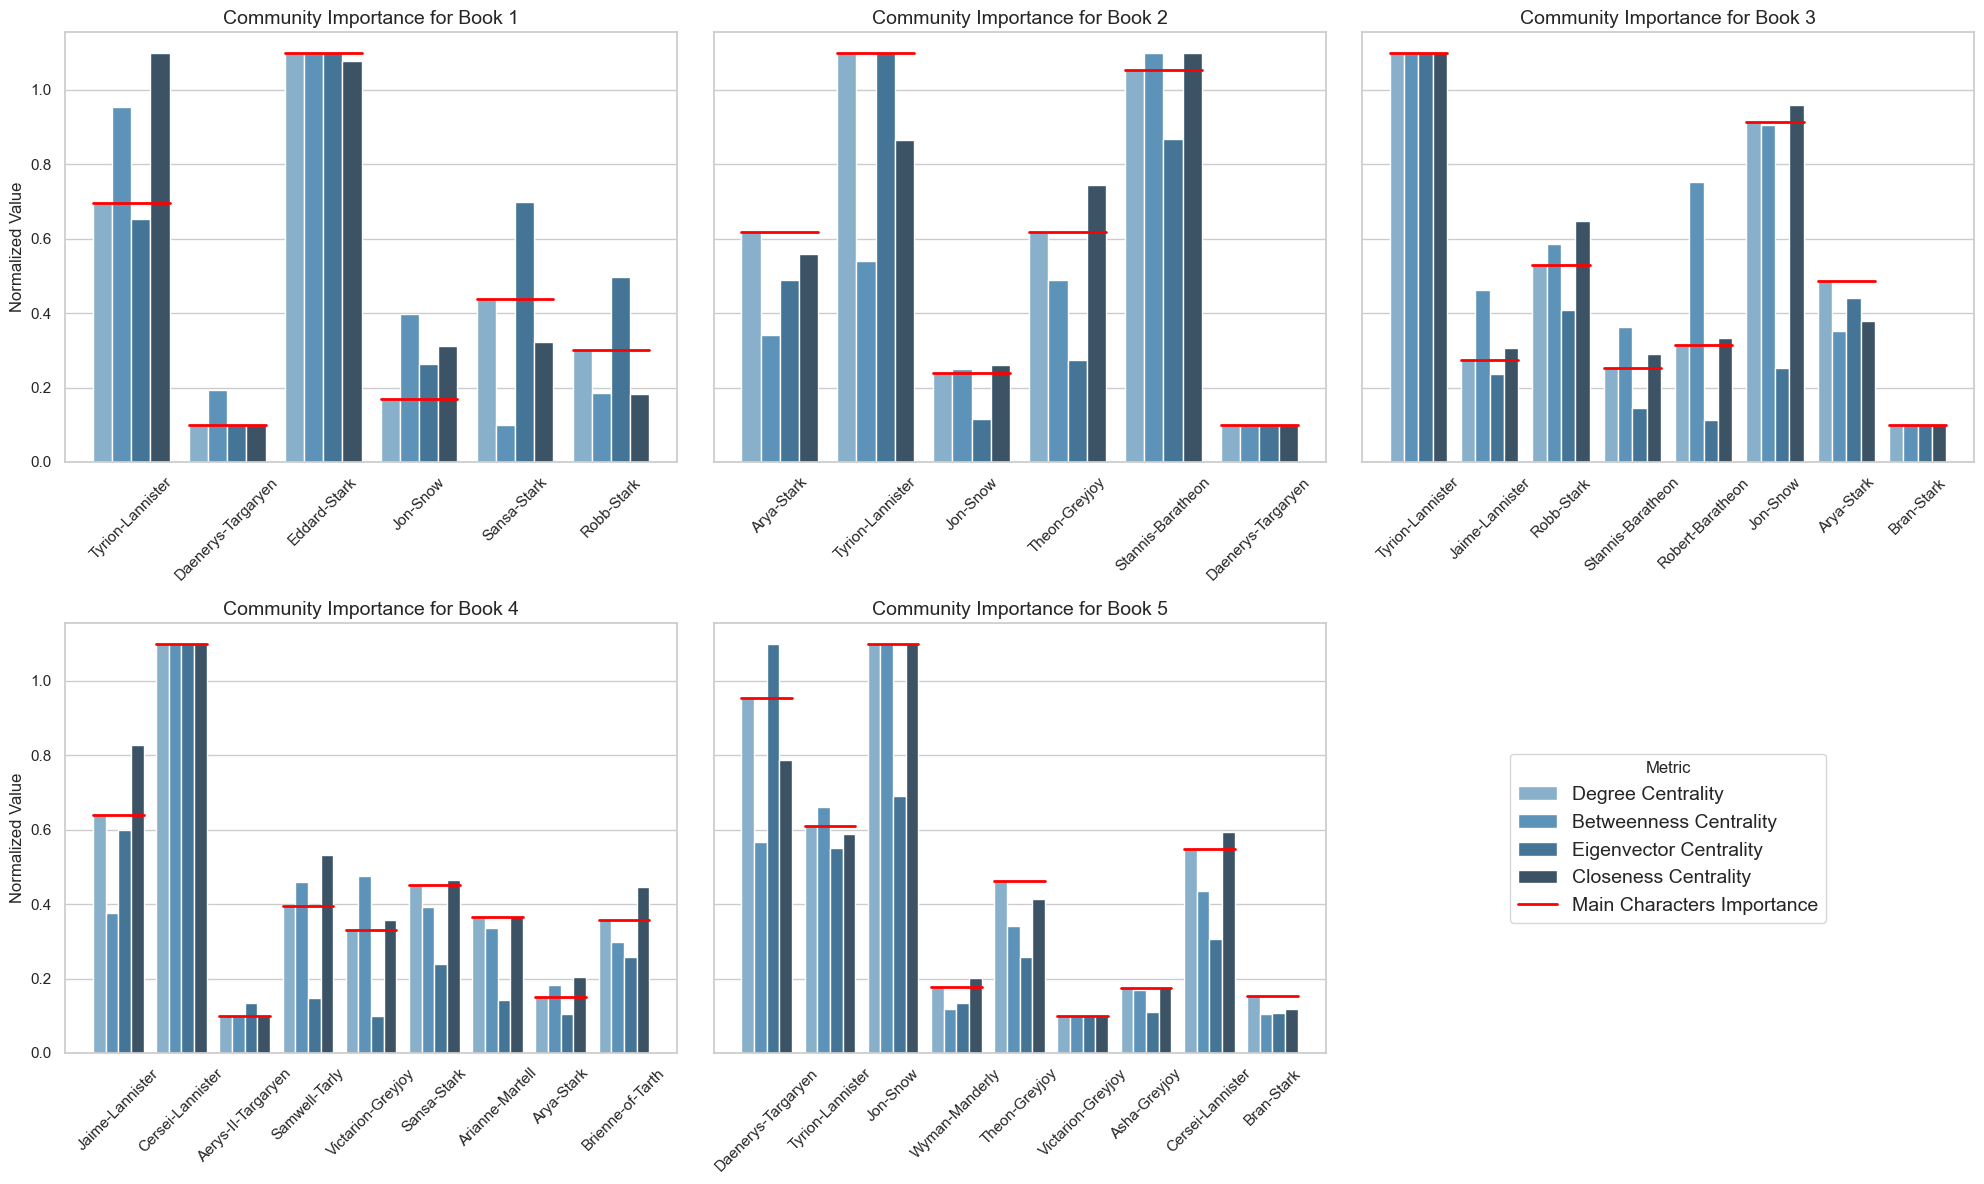

In [9]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Set figure size and layout
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)
axes = axes.flatten()

# Centrality metrics
metrics = ['Degree Centrality', 'Betweenness Centrality', 'Eigenvector Centrality', 'Closeness Centrality']

# Initialize scaler
scaler = MinMaxScaler()

# Plot community importance for each book
for i, book_id in enumerate(books):
    # Get data for the current book
    book_data = importance_df[importance_df['Book'] == book_id]
    
    # Normalize each metric
    book_data[metrics] = scaler.fit_transform(book_data[metrics])
    leader_importance = scaler.fit_transform(book_data[['Degree Centrality']])
    
    # Shift data to avoid zero values
    book_data[metrics] += 0.1
    leader_importance += 0.1
    
    # Convert data to long format
    book_data_long = book_data.melt(id_vars=['Community', 'Leader'], value_vars=metrics, var_name='Metric', value_name='Value')
    
    # Plot bar chart
    sns.barplot(
        x='Leader', 
        y='Value', 
        hue='Metric', 
        data=book_data_long, 
        ax=axes[i],
        palette="Blues_d"  # Set color palette
    )
    
    # Add red solid line for leader importance (degree centrality)
    for j, leader in enumerate(book_data['Leader']):
        leader_value = leader_importance[j][0]
        axes[i].plot([j - 0.4, j + 0.4], [leader_value, leader_value], color='red', linewidth=2)
    
    # Set title and labels
    axes[i].set_title(f'Community Importance for Book {book_id}', fontsize=14)
    axes[i].set_xlabel('')  # Only show X-axis label on the last row
    axes[i].set_ylabel('Normalized Value', fontsize=12)
    
    # Rotate X-axis labels
    axes[i].tick_params(axis='x', rotation=45)
    
    # Remove legend from subplots
    axes[i].get_legend().remove()

# Add a unified legend
handles, labels = axes[0].get_legend_handles_labels()
# Add legend entry for red solid line
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Leader Importance')
handles.append(red_line)
labels.append('Main Characters Importance')

# Place legend in the sixth subplot position
axes[-1].legend(handles, labels, title='Metric', loc='center', fontsize=14)
axes[-1].axis('off')  # Hide the axis of the sixth subplot

# Remove extra subplots
for j in range(len(books), len(axes) - 1):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# Save the plot
# plt.savefig('results/community_importance_plot.png')

plt.show()